In [1]:
import numpy as np
from env.blackjack import BlackjackEnv
from collections import defaultdict

In [2]:
env = BlackjackEnv()
obs_dim = env.observation_space
action_dim = env.action_space.n
print(f"obs_dim:{obs_dim},action_dim:{action_dim}")

obs_dim:Tuple(Discrete(32), Discrete(11), Discrete(2)),action_dim:2


In [3]:
def get_random_probs():
    random_probs = np.ones(action_dim)/action_dim
    return random_probs

In [4]:
def mc_control_with_importance_sampling(env, num_episodes, discount_factor=1.0):
    returns_sum = defaultdict(float)
    Q_values = defaultdict(lambda: np.zeros(action_dim)) # 键是state，值是2维array
    C_values = defaultdict(lambda: np.zeros(action_dim))
    
    for i_episode in range(num_episodes):
        episode = []
        state = env.reset()
        for step in range(100):
            explore_probs = get_random_probs()
            action = np.random.choice(np.arange(len(explore_probs)), p=explore_probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                # print(f"episode_length:{step+1}")
                break
            state = next_state
            
        G = 0
        W = 1
        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t][0], episode[t][1], episode[t][2]
            G = discount_factor * G + reward
            C_values[state][action] += W
            Q_values[state][action] += (W / C_values[state][action])*(G - Q_values[state][action])
            optimize_action = np.argmax(Q_values[state])
            if optimize_action != action:
                break
            W /= (1 / action_dim)

    return Q_values 

#### 蒙特卡洛控制
+ 算法介绍及伪代码可以参考：https://leovan.me/cn/2020/07/model-free-policy-prediction-and-control-monte-carlo-learning/

In [5]:
def plot_value_function(V, title="Optimal Value Function"):
    from matplotlib import pyplot as plt
    import matplotlib
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Holding')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))

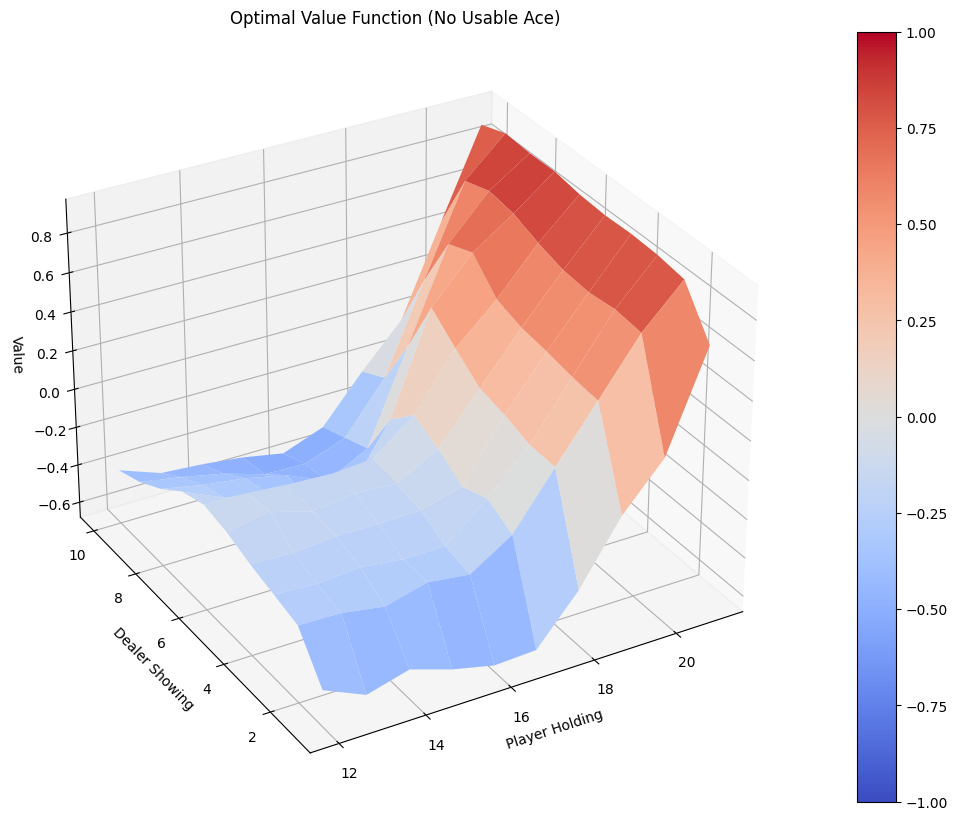

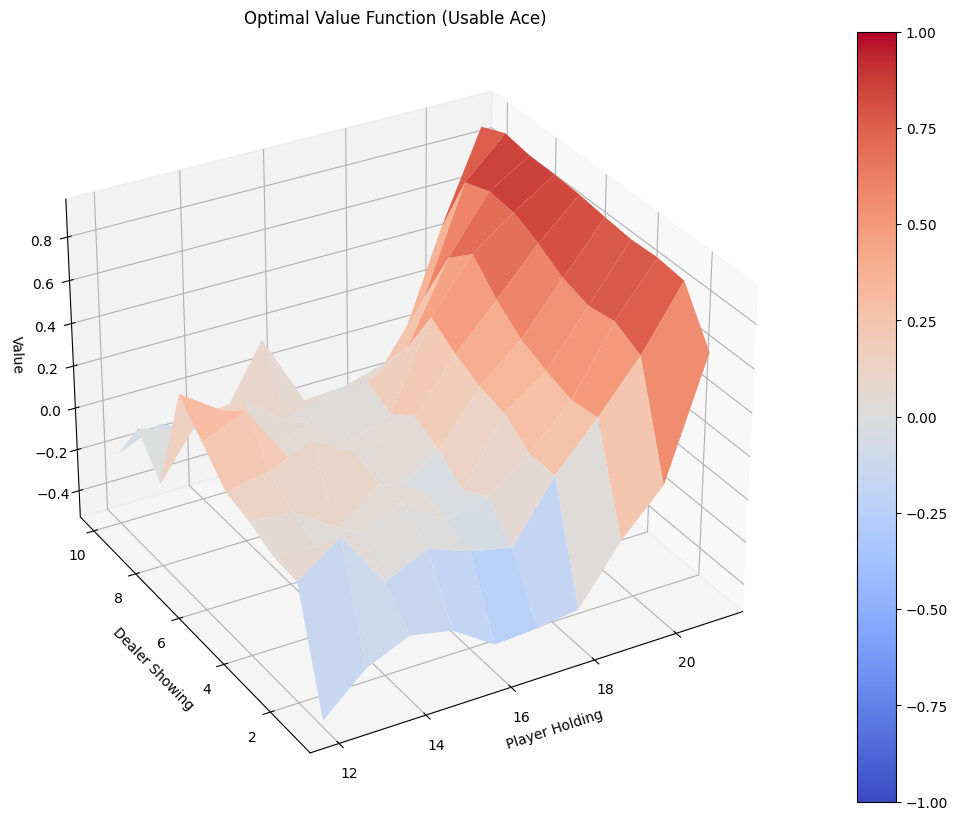

In [6]:
Q_values = mc_control_with_importance_sampling(env, num_episodes=500000)
Values = defaultdict(float)
for state, action_values in Q_values.items():
    action_value = np.max(action_values)
    Values[state] = action_value
plot_value_function(Values)